In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
from herdingspikes.probe import NeuroPixel
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [2]:
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(0)
torch.manual_seed(0)

In [3]:
# raw data location
data_path = 'visapy_data.npy'

In [4]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 15
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [5]:
Probe = HierlmannVisapyEmulationProbe(data_path)
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


In [40]:
# raw data location
data_path = 'rawDataSample.bin'

# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 15
file_directory = 'results/'
file_name = 'ProcessedSpikesNeuropixel'

Probe = NeuroPixel(data_path)
H2 = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

In [42]:
H2.DetectFromRaw()
H2.LoadDetected()

# Sampling rate: 30000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 385
# Analysing frames: 1800000, Seconds:60.0
# Frames before spike in cutout: 30
# Frames after spike in cutout: 66
# tcuts: 42 55
# tInc: 50000
# Analysing 50000 frames; from -42 to 50055
# Analysing 50000 frames; from 49958 to 100055
# Analysing 50000 frames; from 99958 to 150055
# Analysing 50000 frames; from 149958 to 200055
# Analysing 50000 frames; from 199958 to 250055
# Analysing 50000 frames; from 249958 to 300055
# Analysing 50000 frames; from 299958 to 350055
# Analysing 50000 frames; from 349958 to 400055
# Analysing 50000 frames; from 399958 to 450055
# Analysing 50000 frames; from 449958 to 500055
# Analysing 50000 frames; from 499958 to 550055
# Analysing 50000 frames; from 549958 to 600055
# Analysing 50000 frames; from 599958 to 650055
# Analysing 50000 frames; from 649958 to 700055
# Analysing 50000 frames; from 699958 to 750055
# A

# Data Prepping and Split

In [6]:
H.DetectFromRaw()
H.LoadDetected()

# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 750

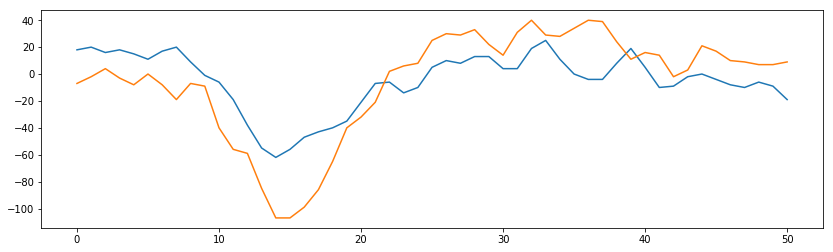

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,4))
for i in [0, 1]:
    plt.plot(H.spikes['Shape'][i])
plt.show()

In [8]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(32826, 51)


In [43]:
length = H2.spikes['Shape'][0].shape[0]
total_sigs = H2.spikes['Shape'].shape[0]

new_electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    new_electrode_data[i, :] = H2.spikes['Shape'][i]
print(new_electrode_data.shape)

(235505, 51)


In [9]:
# min_val = np.amin(electrode_data)
# max_val = np.amax(electrode_data)
# electrode_data = electrode_data/(max_val - min_val)
# electrode_data = electrode_data - np.amin(electrode_data)

# print(np.amin(electrode_data), np.amax(electrode_data))

In [50]:
train_lim = (int)(0.85*electrode_data.shape[0])
val_lim = (int)(0.98*new_electrode_data.shape[0])

electrode_data_train = electrode_data[:train_lim, :]
electrode_data_val = electrode_data[train_lim:val_lim, :]
electrode_data_test = new_electrode_data[val_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (27902, 51)
Test Datasize: (4711, 51)


# Helper Functions

In [11]:
def find_scaled_mse(original, recons, params=None):
    mse = []
    for i in range(original.shape[0]):
        se = (original[i, :] - recons[i, :])**2
        se = se/np.std(original[i, :])
        mse.append(np.mean(se))
    if params is not None:
        print(params, np.median(mse))
    mse = np.array(mse)
    return mse, np.median(mse)

In [12]:
# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def plot_correlation(dict_of_outputs):
    plt.figure(figsize=(14,8))

    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    size = len(keys)/2 *100 + 20
    
    for i in range(len(keys)):
        plt.subplot(size+i)
        plt.scatter(electrode_data_test, vals[i], s=0.5)
        plt.title(str(keys[i]))
    plt.show()

In [13]:
# dict_of_outputs = {'AE_2': [<list>], 'AE_4':[<list>], ... 'PCA':[<list>], 'Original': [<list>]}

def gen_boxplots(dict_of_outputs, filename, figsize = (7,5), ylabel=""):
    fig = plt.figure(1, figsize=figsize)
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    
    ax = fig.add_subplot(111)
    ax.boxplot(vals, showfliers=False, notch=True)
    ax.grid()
    ax.set_xticklabels(keys)
    plt.xlabel('Autoencoder Models', fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    fig.savefig(filename, bbox_inches='tight')
    plt.show()

In [14]:
# dict_of_outputs = {'AE_2': [<np.array>], 'AE_4':[<np.array>], ... 'PCA':[<np.array>], 'Original': [<np.array>]}

def find_correlation_coeff(dict_of_outputs, plot = True):
    
    keys = list(dict_of_outputs.keys())
    vals = list(dict_of_outputs.values())
    corrs = {}
    for i in range(len(keys)):
        corrs[keys[i]] = [np.corrcoef(electrode_data_test[j],vals[i][j])[0,1] 
                             for j in range(electrode_data_test.shape[0])]
    holder = []
    for i in keys:
        #print(i, np.median(corrs[i]))
        holder.append((i, np.median(corrs[i])))
    if plot:
        gen_boxplots(corrs)
    else:
        return holder, corrs

In [15]:
def comp_pca(components):
    pca = PCA(n_components=components)
    pca.fit(electrode_data_train)
    e_data_pca = pca.transform(electrode_data_test)
    e_data_proj = pca.inverse_transform(e_data_pca)
    return e_data_proj

In [16]:
def get_network_output(model, embedding):
    enc_final = np.zeros([electrode_data_test.shape[0], embedding])
    out_final = np.zeros([electrode_data_test.shape[0], 51])

    for i in range(electrode_data_test.shape[0]):
        data = electrode_data_test[i, :]
        data = torch.from_numpy(data).float()

        enc, o = model.forward(data)
        o = (o.data).cpu().numpy()
        enc = (enc.data).cpu().numpy()

        enc_final[i, :] = enc[:]
        out_final[i, :] = o[:]
    
    return enc_final, out_final

# DEFINING MODELS

In [21]:
random.seed(0)

def train_ae(model, input_data, val_data, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    v_losses = []
    mdl_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('TOTAL PARAMETERS FOR MODEL:', mdl_total_params)
    
    for num_epoch in range(1, epoch_range+1):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        x = np.zeros((batch_size, 51))
        for i, feats in enumerate(selected):
            x[i, :] = input_data[feats, :]
        x = torch.from_numpy(x).float().cuda()
        #---------FORWARD------------#
        enc, out = model.forward(x)
        out = torch.tensor(out).float().cuda()
        loss = criterion(out, x)
        #---------BACKWARD------------#
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        v = random.sample(range(0, len(electrode_data_val)), 20)
        v_data = np.zeros((20, 51))
        for i, feats in enumerate(v):
            v_data[i, :] = electrode_data_val[feats, :]
        v_data = torch.from_numpy(v_data).float().cuda()
        _, v_out = model.forward(v_data)
        v_out = torch.tensor(v_out).float().cuda()
        vloss = criterion(v_out, v_data)
        
        losses.append(loss.data[0])
        v_losses.append(vloss.data[0])
        if num_epoch%14000 == 0:
            print('epoch [{}/{}], loss:{:.8f}, val:{:.8f} //'.format(num_epoch, epoch_range, 
                                                              loss.data[0], vloss.data[0]))
    return enc, out, losses, v_losses

def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

## Simple Shallow

In [17]:
# input -> 50 -> 12 -> emb -> 12 -> 50 -> input

class autoencoder_shallow(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_shallow, self).__init__()
        activation_layer = nn.ELU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 50),
                                     activation_layer,
                                     nn.Linear(50, 12),
                                     activation_layer,
                                     nn.Linear(12, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 12),
                                     activation_layer,
                                     nn.Linear(12, 50),
                                     activation_layer,
                                     nn.Linear(50, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [23]:
# Training the AE for encoder1

# Training for 4 embeddings

epoch_range = 350000
batch_size = 300
learning_rate = 0.0001

# embedding_size = 4

# ae_14 = autoencoder_shallow(length, embedding_size).cuda()
# ae_14.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_14.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_14 = train_ae(ae_14, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_12 = autoencoder_shallow(length, embedding_size).cuda()
ae_12.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_12.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_12, vlosses_12 = train_ae(ae_12, electrode_data_train, electrode_data_val, criterion, optimizer, epoch_range, batch_size)

TOTAL PARAMETERS FOR MODEL: 6525
epoch [14000/350000], loss:133.77397156, val:157.89314270 //
epoch [28000/350000], loss:139.84814453, val:106.37832642 //
epoch [42000/350000], loss:121.15890503, val:115.80863953 //
epoch [56000/350000], loss:118.95087433, val:133.60995483 //
epoch [70000/350000], loss:118.45823669, val:125.10697174 //
epoch [84000/350000], loss:119.60176849, val:98.54985809 //
epoch [98000/350000], loss:115.06348419, val:116.57034302 //
epoch [112000/350000], loss:122.29524231, val:91.84107971 //
epoch [126000/350000], loss:117.12342834, val:81.59330750 //
epoch [140000/350000], loss:111.25936127, val:102.36208344 //
epoch [154000/350000], loss:114.48857880, val:105.86136627 //
epoch [168000/350000], loss:103.78019714, val:145.18870544 //
epoch [182000/350000], loss:107.65885925, val:118.31267548 //
epoch [196000/350000], loss:111.14107513, val:93.78170013 //
epoch [210000/350000], loss:108.63797760, val:103.79638672 //
epoch [224000/350000], loss:96.50579071, val:84.

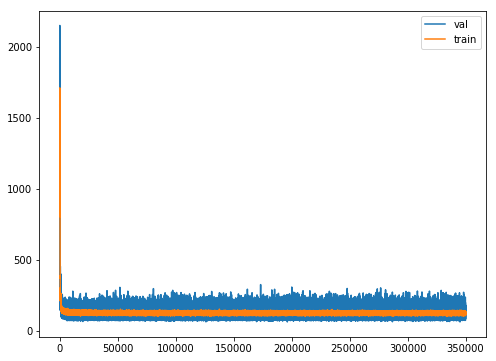

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(vlosses_12, label="val")
plt.plot(losses_12, label="train")
plt.legend()
plt.show()

In [21]:
ae_1 = torch.load('models/final_models/ae_1_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/final_models/ae_1_4.pt', map_location=lambda storage, loc: storage)

AE 0.9473261786377375
PCA 0.9473133023945347


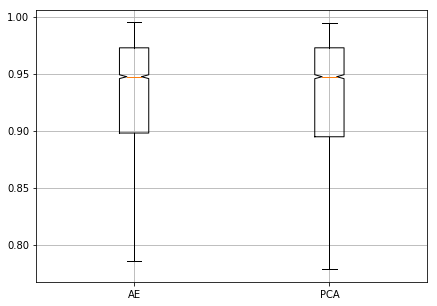

In [22]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 3.2281291754661194
AE 3.2096299964494976


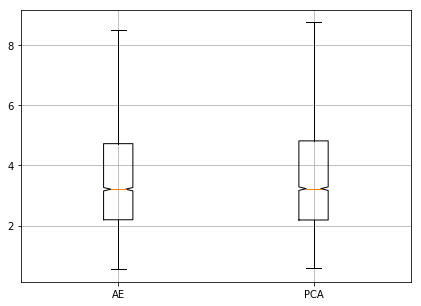

In [23]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

## Simple Deep

In [18]:
# input -> 100 -> 50 -> 25 -> 12 -> emb -> 12 -> 25 -> 50 -> 100 -> input

class autoencoder_deep(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_deep, self).__init__()
        activation_layer = nn.ELU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 12),
                                     activation_layer,
                                     nn.Linear(12, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 12),
                                     activation_layer,
                                     nn.Linear(12, 25),
                                     activation_layer,
                                     nn.Linear(25, 50),
                                     activation_layer,
                                     nn.Linear(50, 100),
                                     activation_layer,
                                     nn.Linear(100, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [25]:
# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 350000
batch_size = 300
learning_rate = 0.0001

# embedding_size = 4

# ae_44 = autoencoder_deep(length, embedding_size).cuda()
# ae_44.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_44.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_44 = train_ae(ae_44, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_42 = autoencoder_deep(length, embedding_size).cuda()
ae_42.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_42.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_42, vlosses_42 = train_ae(ae_42, electrode_data_train, electrode_data_val, criterion, optimizer, epoch_range, batch_size)


TOTAL PARAMETERS FOR MODEL: 23775
epoch [14000/350000], loss:133.19377136, val:126.84635162 //
epoch [28000/350000], loss:121.71154785, val:145.52410889 //
epoch [42000/350000], loss:109.89349365, val:135.98355103 //
epoch [56000/350000], loss:108.89591980, val:96.93286133 //
epoch [70000/350000], loss:109.61828613, val:91.52054596 //
epoch [84000/350000], loss:100.18650818, val:99.09842682 //
epoch [98000/350000], loss:97.15413666, val:106.10427094 //
epoch [112000/350000], loss:94.58521271, val:121.64845276 //
epoch [126000/350000], loss:98.07434845, val:83.55633545 //
epoch [140000/350000], loss:102.93722534, val:101.47187805 //
epoch [154000/350000], loss:97.98131561, val:124.87371063 //
epoch [168000/350000], loss:98.69131470, val:98.59352112 //
epoch [182000/350000], loss:91.36276245, val:115.17963409 //
epoch [196000/350000], loss:99.80028534, val:117.32888031 //
epoch [210000/350000], loss:102.04296112, val:93.09493256 //
epoch [224000/350000], loss:95.07508850, val:86.03737640

In [26]:
ae_1 = torch.load('models/final_models/ae_4_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/final_models/ae_4_4.pt', map_location=lambda storage, loc: storage)

AE 0.9591819833352391
PCA 0.9473133023945346


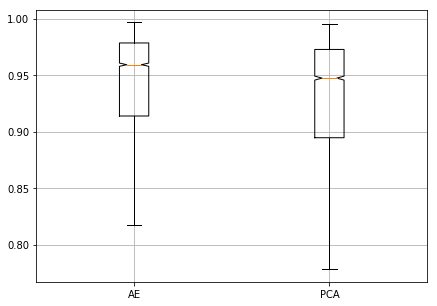

In [27]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 3.2281291754661536
AE 2.846862706297798


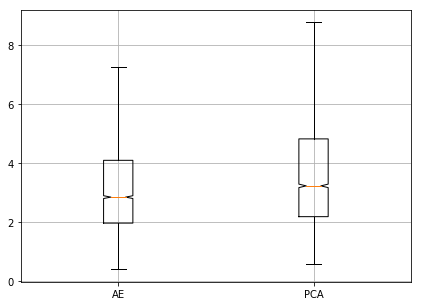

In [28]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

## Deep Encoder - Shallow Decoder Variation

In [19]:
# input -> 80 -> 40 -> 25 -> 15 -> 10 -> emb -> 10 -> 25 -> 80 -> input

class autoencoder_var(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_var, self).__init__()
        activation_layer = nn.LeakyReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 15),
                                     activation_layer,
                                     nn.Linear(15, 10),
                                     activation_layer,
                                     nn.Linear(10, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 10),
                                     activation_layer,
                                     nn.Linear(10, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [27]:
# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 350000
batch_size = 300
learning_rate = 0.0001

# embedding_size = 4

# ae_54 = autoencoder_var(length, embedding_size).cuda()
# ae_54.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_54.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_54 = train_ae(ae_54, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_52 = autoencoder_var(length, embedding_size).cuda()
ae_52.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_52.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_52, vlosses_52 = train_ae(ae_52, electrode_data_train, electrode_data_val, criterion, optimizer, epoch_range, batch_size)

TOTAL PARAMETERS FOR MODEL: 18613
epoch [14000/350000], loss:134.45323181, val:191.03376770 //
epoch [28000/350000], loss:117.35370636, val:211.75122070 //
epoch [42000/350000], loss:104.83549500, val:96.34918976 //
epoch [56000/350000], loss:104.21092987, val:91.69326019 //
epoch [70000/350000], loss:102.26351166, val:87.55563354 //
epoch [84000/350000], loss:108.12587738, val:83.77169037 //
epoch [98000/350000], loss:112.68068695, val:107.56107330 //
epoch [112000/350000], loss:108.11248016, val:86.57131195 //
epoch [126000/350000], loss:106.38536835, val:102.96180725 //
epoch [140000/350000], loss:106.30061340, val:93.04401398 //
epoch [154000/350000], loss:100.66125488, val:112.15243530 //
epoch [168000/350000], loss:108.54472351, val:84.45376587 //
epoch [182000/350000], loss:103.65347290, val:117.98504639 //
epoch [196000/350000], loss:107.60517883, val:99.51243591 //
epoch [210000/350000], loss:104.73597717, val:94.84874725 //
epoch [224000/350000], loss:115.92413330, val:93.566

In [31]:
ae_1 = torch.load('models/final_models/ae_5_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/final_models/ae_5_4.pt', map_location=lambda storage, loc: storage)

AE 0.9583042206125387
PCA 0.9473133023945345


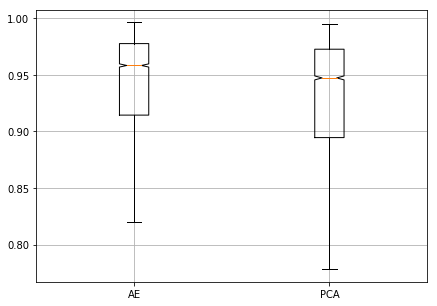

In [32]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca}
find_correlation_coeff(d)

PCA 3.2281291754662336
AE 2.715969777608768


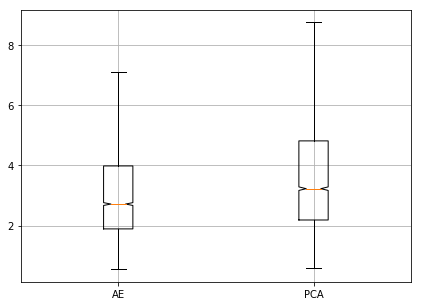

In [33]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

# Super Deep Encoder

In [20]:
# input -> 100 -> 50 -> 25 -> 12 -> emb -> 12 -> 25 -> 50 -> 100 -> input

class autoencoder_sdeep(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_sdeep, self).__init__()
        activation_layer = nn.ELU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 80),
                                     activation_layer,
                                     nn.Linear(80, 60),
                                     activation_layer,
                                     nn.Linear(60, 45),
                                     activation_layer,
                                     nn.Linear(45, 25),
                                     activation_layer,
                                     nn.Linear(25, 12),
                                     activation_layer,
                                     nn.Linear(12, 8),
                                     activation_layer,
                                     nn.Linear(8, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 8),
                                     activation_layer,
                                     nn.Linear(8, 12),
                                     activation_layer,
                                     nn.Linear(12, 25),
                                     activation_layer,
                                     nn.Linear(25, 45),
                                     activation_layer,
                                     nn.Linear(45, 60),
                                     activation_layer,
                                     nn.Linear(60, 80),
                                     activation_layer,
                                     nn.Linear(80, 100),
                                     activation_layer,
                                     nn.Linear(100, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [29]:
# Training the AE for encoder4

# Training for 4 embeddings

epoch_range = 350000
batch_size = 300
learning_rate = 0.0001

# embedding_size = 4

# ae_54 = autoencoder_sdeep(length, embedding_size).cuda()
# ae_54.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_54.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_54 = train_ae(ae_54, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# Training for 2 embeddings

embedding_size = 2

ae_52 = autoencoder_sdeep(length, embedding_size).cuda()
ae_52.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_52.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_52, vlosses_52 = train_ae(ae_52, electrode_data_train, electrode_data_val, criterion, optimizer, epoch_range, batch_size)

TOTAL PARAMETERS FOR MODEL: 44987
epoch [14000/350000], loss:132.50491333, val:104.49935913 //
epoch [28000/350000], loss:121.29239655, val:138.84870911 //
epoch [42000/350000], loss:119.23169708, val:93.83106995 //
epoch [56000/350000], loss:121.34082031, val:98.63648987 //
epoch [70000/350000], loss:105.16995239, val:117.81313324 //
epoch [84000/350000], loss:100.70095062, val:96.73780823 //
epoch [98000/350000], loss:98.58462524, val:85.37267303 //
epoch [112000/350000], loss:107.88536072, val:91.68575287 //
epoch [126000/350000], loss:102.81056213, val:94.58239746 //
epoch [140000/350000], loss:98.22351837, val:83.48336792 //
epoch [154000/350000], loss:99.59355164, val:83.33250427 //
epoch [168000/350000], loss:93.96716309, val:95.67626190 //
epoch [182000/350000], loss:102.90742493, val:124.73711395 //
epoch [196000/350000], loss:101.93348694, val:80.15288544 //
epoch [210000/350000], loss:96.72300720, val:92.23898315 //
epoch [224000/350000], loss:99.04874420, val:87.60378265 //

In [36]:
ae_1 = torch.load('models/final_models/ae_6_2.pt', map_location=lambda storage, loc: storage)
#ae_2 = torch.load('models/final_models/ae_6_4.pt', map_location=lambda storage, loc: storage)

AE 0.958274180962378
PCA 0.9473133023945339
Baseline 0.9406087594335943


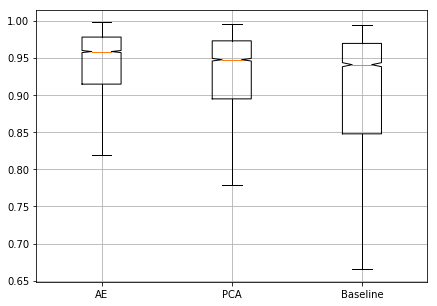

In [37]:
_, out_ae = get_network_output(ae_1, 2)
out_pca = comp_pca(2)
d = {'AE': out_ae, 'PCA': out_pca, "Baseline": comp_pca(0)}
find_correlation_coeff(d)

In [38]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
out_base = np.zeros((electrode_data_test.shape[0], 51))
for i in range(51):
    out_base[:, i] = np.mean(electrode_data_test[:, i])
baseline = find_scaled_mse(electrode_data_test, out_base, 'Baseline')

PCA 3.2281291754662043
AE 2.8023538603597147
Baseline 10.523882220300688


PCA 3.2281291754662043
AE 2.8023538603597147
Baseline 10.523882220300688


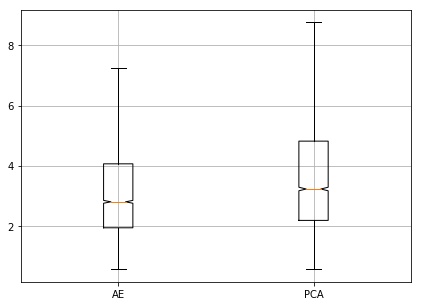

In [39]:
pca_mse = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
ae_mse = find_scaled_mse(electrode_data_test, out_ae, 'AE')
out_base = np.zeros((electrode_data_test.shape[0], 51))
for i in range(51):
    out_base[:, i] = np.mean(electrode_data_test[:, i])
baseline = find_scaled_mse(electrode_data_test, out_base, 'Baseline')
gen_boxplots({'AE': ae_mse, 'PCA': pca_mse})

In [40]:
def relative_improvement(ae_data, pca_data, baseline):
    ae_improv = np.abs((np.median(baseline) - np.median(ae_data))/np.median(baseline))
    ae_improv *= 100

    pca_improv = np.abs((np.median(baseline) - np.median(pca_data))/np.median(baseline))
    pca_improv *= 100

    print("Baseline Value: ", np.median(baseline))
    print("AE Value: ", np.median(ae_data))
    print("PCA Value: ", np.median(pca_data))
    print('\n AE improvement: ', ae_improv)
    print('PCA improvement: ', pca_improv)

In [41]:
# Correlation Coefficient Improvement

d = {'AE': out_ae, 'PCA': out_pca, 'Baseline': comp_pca(0)}
meds = find_correlation_coeff(d, plot=False)

print(meds)
relative_improvement(meds[0][1], meds[1][1], meds[2][1])

AE 0.958274180962378
PCA 0.9473133023945339
Baseline 0.9406087594335943
[('AE', 0.958274180962378), ('PCA', 0.9473133023945339), ('Baseline', 0.9406087594335943)]
Baseline Value:  0.9406087594335943
AE Value:  0.958274180962378
PCA Value:  0.9473133023945339

 AE improvement:  1.8780838846771182
PCA improvement:  0.7127876381862375


In [42]:
# MSE Improvement
relative_improvement(ae_mse, pca_mse, baseline)

Baseline Value:  10.523882220300688
AE Value:  2.8023538603597147
PCA Value:  3.2281291754662043

 AE improvement:  73.37148210425671
PCA improvement:  69.32568126580601


# Asymmetric Single Decoder

In [21]:
# input -> 80 -> 40 -> 25 -> 15 -> 10 -> emb -> 10 -> 25 -> 80 -> input

class autoencoder_sd(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder_sd, self).__init__()
        activation_layer = nn.LeakyReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 15),
                                     activation_layer,
                                     nn.Linear(15, 10),
                                     activation_layer,
                                     nn.Linear(10, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 51))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

# Training the AE for encoder4

# Training for 4 embeddings

# epoch_range = 350000
# batch_size = 300
# learning_rate = 0.0001

# # embedding_size = 4

# # ae_54 = autoencoder_var(length, embedding_size).cuda()
# # ae_54.apply(init_weights)
# # criterion = nn.MSELoss()
# # optimizer = torch.optim.Adam(
# #     ae_54.parameters(), lr=learning_rate, weight_decay=0.001)

# # enc, out, losses_54 = train_ae(ae_54, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

# # Training for 2 embeddings

# embedding_size = 2

# ae_82 = autoencoder_sd(length, embedding_size).cuda()
# ae_82.apply(init_weights)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
#     ae_82.parameters(), lr=learning_rate, weight_decay=0.001)

# enc, out, losses_82, vlosses_82 = train_ae(ae_82, electrode_data_train, electrode_data_val, criterion, optimizer, epoch_range, batch_size)

In [24]:
sym_deepest, sym_deep, sym_shallow, asym_mult, asym_single = None, None, None, None, None

In [25]:
def load_all_models():
    global sym_deepest, sym_deep, sym_shallow, asym_mult, asym_single
    sym_deepest = torch.load('models/final_models/ae_6_2.pt', map_location=lambda storage, loc: storage)
    sym_deep = torch.load('models/final_models/ae_4_2.pt', map_location=lambda storage, loc: storage)
    sym_shallow = torch.load('models/final_models/ae_1_2.pt', map_location=lambda storage, loc: storage)
    
    asym_mult = torch.load('models/final_models/ae_5_2.pt', map_location=lambda storage, loc: storage)
    asym_single = torch.load('models/final_models/ae_8_2.pt', map_location=lambda storage, loc: storage)

In [26]:
load_all_models()

In [27]:
def find_cor_and_mse(ae):
    _, out_ae = get_network_output(ae, 2)
    ae_mse, mse_med = find_scaled_mse(electrode_data_test, out_ae)
    a, b = find_correlation_coeff({'AE': out_ae}, plot=False)
    ae_cor_med = a[0][1]
    ae_corrs = np.array(b['AE'])
    return ae_mse, ae_corrs, mse_med, ae_cor_med

In [28]:
find_cor_and_mse(asym_mult)

(array([1.53314967, 1.68083863, 4.13051913, ..., 1.07557409, 1.74246595,
        2.27160725]),
 array([0.97500724, 0.97744873, 0.95203837, ..., 0.9883609 , 0.9589346 ,
        0.96367136]),
 2.715969777608768,
 0.9583042206125387)

In [70]:
# Asym Single: 12250
# Asym Multi: 18613
# Sym Superdeep: 44987
# Sym Deep: 23775
# Sym Shallow: 6525

In [51]:
out_pca = comp_pca(2)
pca_mse, pca_med = find_scaled_mse(electrode_data_test, out_pca, 'PCA')
a, b = find_correlation_coeff({'PCA': out_pca}, plot=False)
pca_cor_med = a[0][1]
pca_corrs = np.array(b['PCA'])

PCA 10.439677556501707


In [90]:
# out_base = comp_pca(0)
# base_mse, base_med = find_scaled_mse(electrode_data_test, out_base, 'Baseline')
# a, b = find_correlation_coeff({'Baseline': out_base}, plot=False)
# base_cor_med = a[0][1]
# base_corrs = np.array(b['Baseline'])

Baseline 10.204287245214399


In [52]:
#sym_deepest, sym_deep, sym_shallow, asym_mult, asym_single = None, None, None, None, None

ae_1_mse, ae_1_cor, ae_1_mse_med, ae_1_cor_med = find_cor_and_mse(sym_shallow)
ae_2_mse, ae_2_cor, ae_2_mse_med, ae_2_cor_med = find_cor_and_mse(sym_deep)
ae_3_mse, ae_3_cor, ae_3_mse_med, ae_3_cor_med = find_cor_and_mse(sym_deepest)
ae_4_mse, ae_4_cor, ae_4_mse_med, ae_4_cor_med = find_cor_and_mse(asym_single)
ae_5_mse, ae_5_cor, ae_5_mse_med, ae_5_cor_med = find_cor_and_mse(asym_mult)

# MSE Boxplots [FOR NEUROPIXELS]

In [31]:
dict_of_mse = {"Asym. AE \n(18613)": ae_5_mse, "PCA": pca_mse}

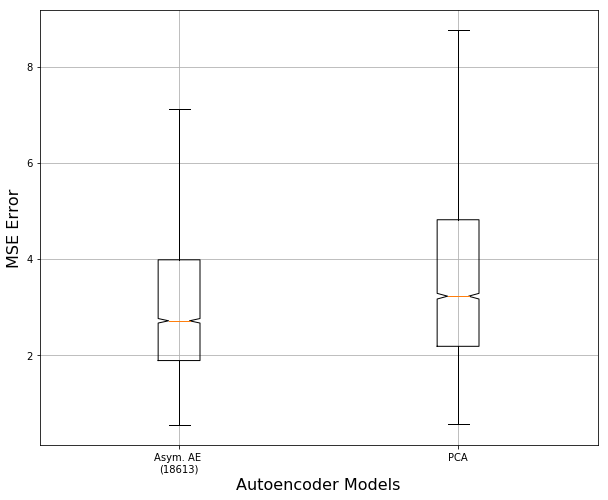

In [32]:
gen_boxplots(dict_of_mse, filename="neuropix_mse.pdf", figsize=(10, 8), ylabel="MSE Error")

In [53]:
dict_of_mse = {"Asym. AE \n(18613)": ae_5_mse, "PCA": pca_mse}
for i, val in enumerate(dict_of_mse.values()):
    print(np.median(val))

8.60408000841855
10.439677556501707


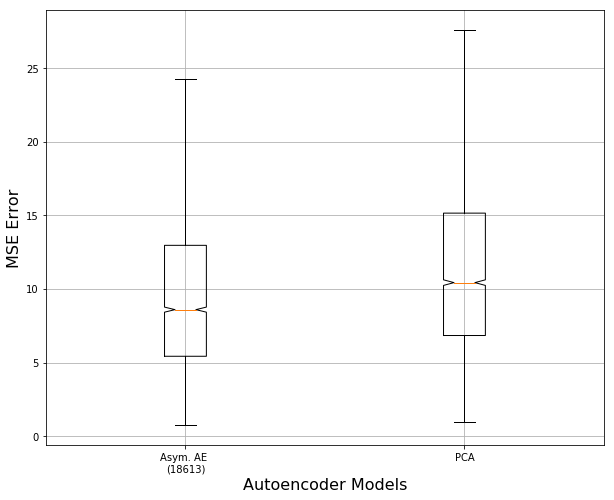

In [54]:
gen_boxplots(dict_of_mse, filename="neuropix_mse.pdf", figsize=(10, 8), ylabel="MSE Error")

# Correlation Plots

In [55]:
dict_of_cor = {"Asym. AE \n(18613)": ae_5_cor, "PCA": pca_corrs}
for i, val in enumerate(dict_of_cor.values()):
    print(np.median(val))

0.7702991898833704
0.7013456908490873


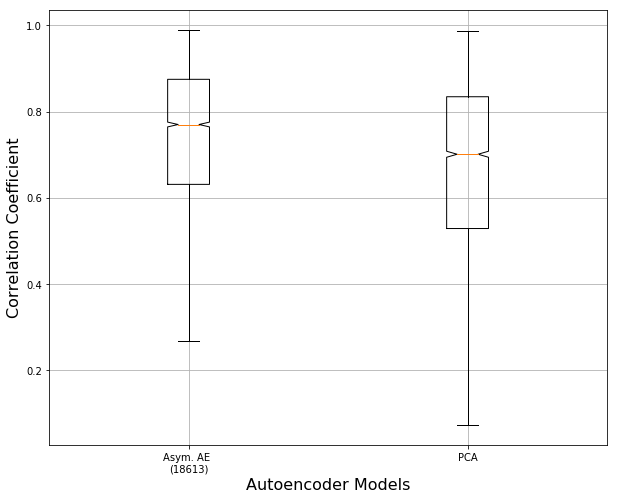

In [56]:
gen_boxplots(dict_of_cor, filename="neuropix_corr.pdf", figsize=(10, 8), ylabel="Correlation Coefficient")

In [109]:
print("Sym. AE (6525) & ", ae_1_mse_med, "\nSym. AE (23775) & ", ae_2_mse_med, "\nSym. AE (44987) & ", ae_3_mse_med, 
        "\nAsym. AE (12250) & ", ae_4_mse_med, "\nAsym. AE (18613) & ", ae_5_mse_med, "\nPCA & ", pca_med, 
      "\nBaseline & ", base_med)

Sym. AE (6525) &  3.2096299964494976 
Sym. AE (23775) &  2.846862706297798 
Sym. AE (44987) &  2.8023538603597147 
Asym. AE (12250) &  3.2457608474152595 
Asym. AE (18613) &  2.715969777608768 
PCA &  3.228129175466237 
Baseline &  10.204287245214399


In [172]:
print("Sym. AE (6525) & ", ae_1_cor_med, "\nSym. AE (23775) & ", ae_2_cor_med, "\nSym. AE (44987) & ", ae_3_cor_med, 
        "\nAsym. AE (12250) & ", ae_4_cor_med, "\nAsym. AE (18613) & ", ae_5_cor_med, "\nPCA & ", pca_cor_med, 
      "\nBaseline & ", base_cor_med)

Sym. AE (6525) &  0.9473261786377375 
Sym. AE (23775) &  0.9591819833352391 
Sym. AE (44987) &  0.958274180962378 
Asym. AE (12250) &  0.9466588347032371 
Asym. AE (18613) &  0.9583042206125387 
PCA &  0.9473133023945336 
Baseline &  0.9406087594335943


# Best Model Reconstruction

In [38]:
_, out_ae = get_network_output(asym_mult, 2)

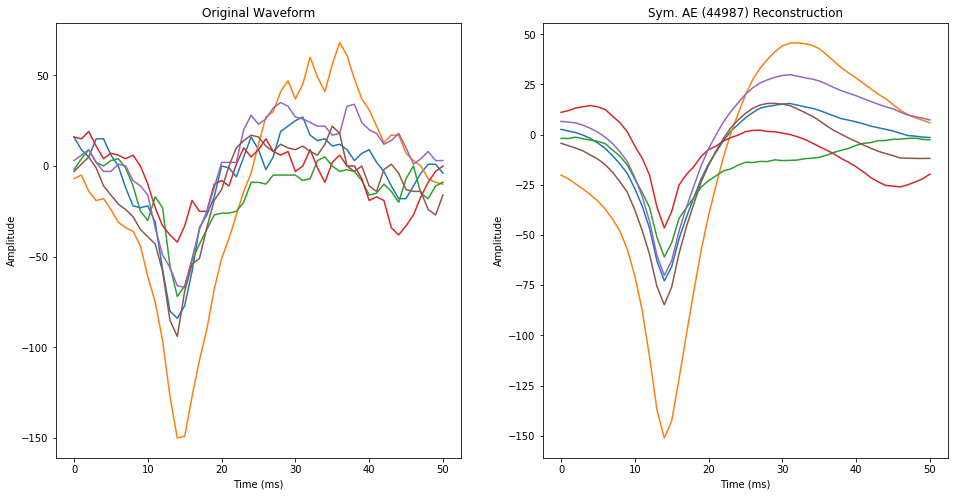

In [39]:
n = sorted([11, 290, 3490, 1098, 2707, 9])

fig1 = plt.figure(figsize=(16, 8))

for i in n:
    plt.subplot(122)
    plt.plot(out_ae[i, :])
    plt.title('Sym. AE (44987) Reconstruction')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.subplot(121)
    plt.plot(electrode_data_test[i, :])
    plt.title('Original Waveform')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
fig1.savefig("recons1.png", bbox_inches='tight')

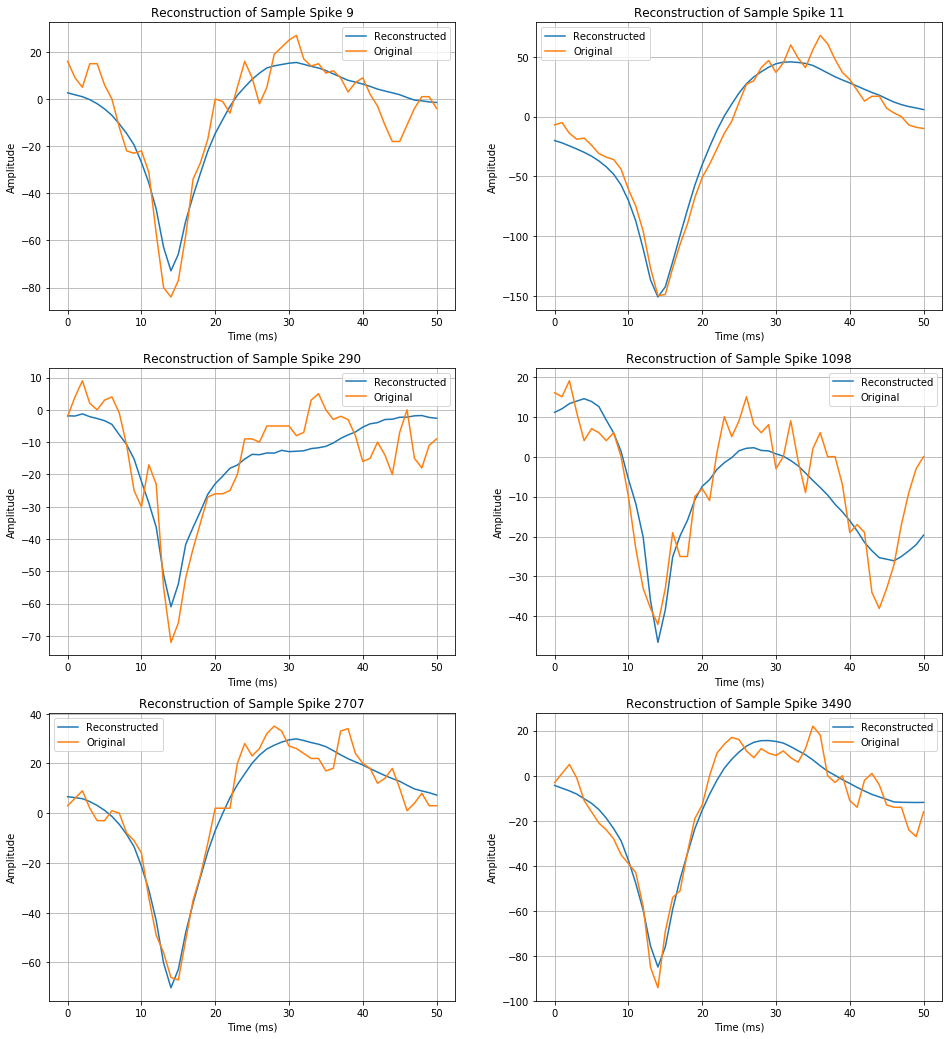

In [175]:
fig2 = plt.figure(figsize=(16, 18))

index = 0
for i in n:
    index += 1
    plt.subplot(320+index)
    plt.title('Reconstruction of Sample Spike '+str(i))
    plt.plot(out_ae[i, :], label="Reconstructed")
    plt.plot(electrode_data_test[i, :], label="Original")
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.legend()
plt.show()
fig2.savefig("recons2.png", bbox_inches='tight')

# Shallow Model Reconstruction

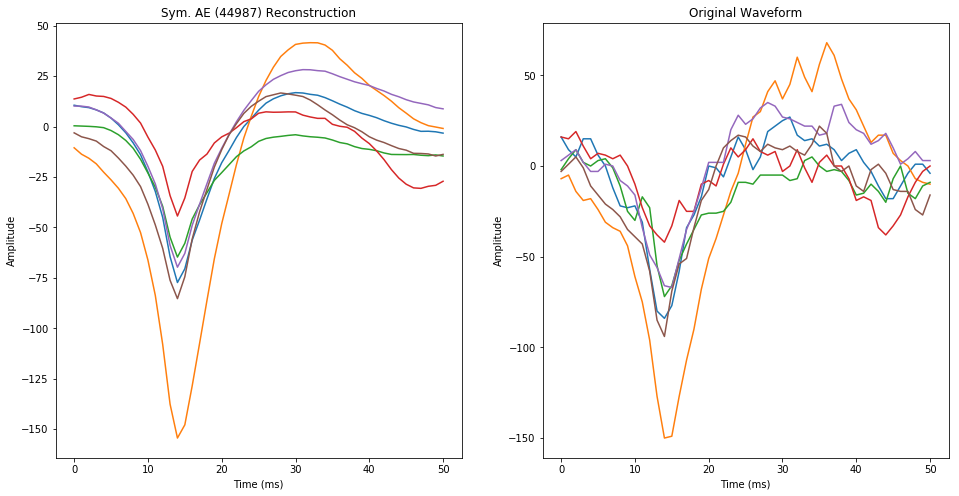

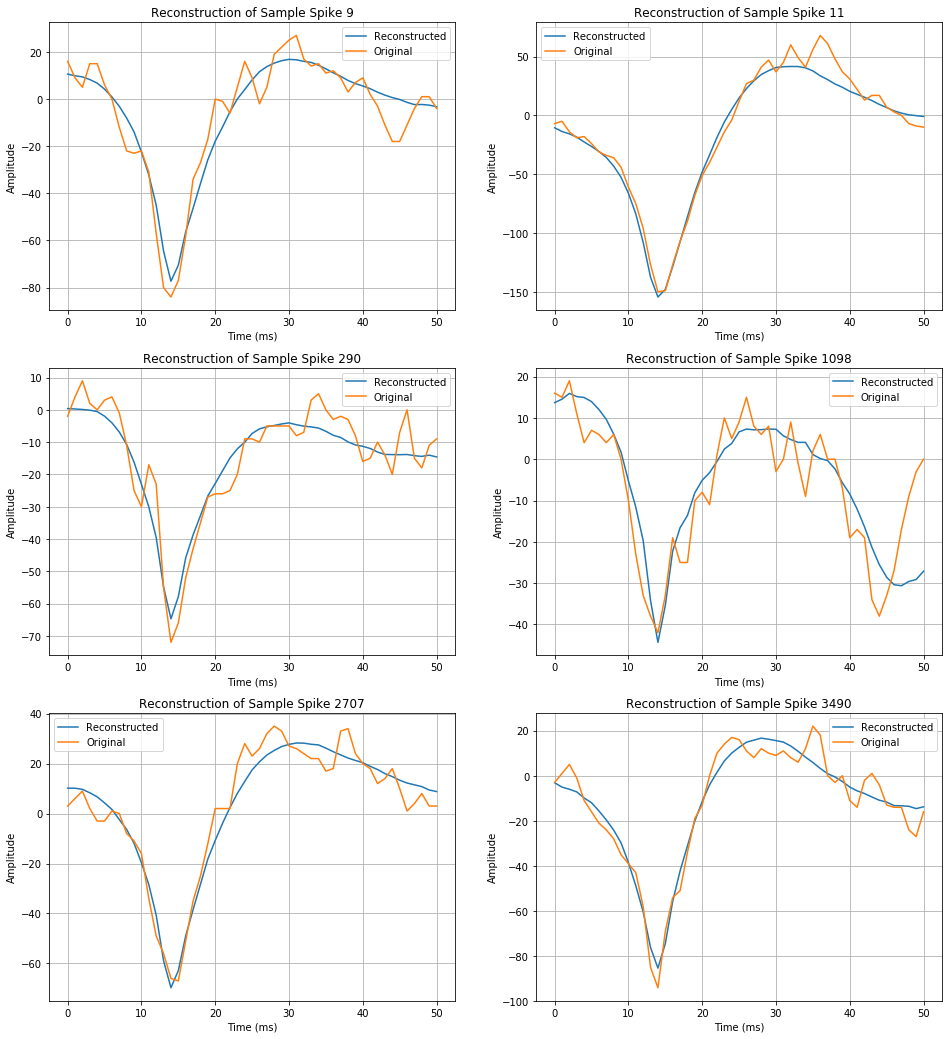

In [176]:
_, out_ae = get_network_output(sym_deepest, 2)

n = sorted([11, 290, 3490, 1098, 2707, 9])

fig1 = plt.figure(figsize=(16, 8))

for i in n:
    plt.subplot(121)
    plt.plot(out_ae[i, :])
    plt.title('Sym. AE (44987) Reconstruction')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.subplot(122)
    plt.plot(electrode_data_test[i, :])
    plt.title('Original Waveform')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')

fig2 = plt.figure(figsize=(16, 18))

index = 0
for i in n:
    index += 1
    plt.subplot(320+index)
    plt.title('Reconstruction of Sample Spike '+str(i))
    plt.plot(out_ae[i, :], label="Reconstructed")
    plt.plot(electrode_data_test[i, :], label="Original")
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.legend()
plt.show()

In [165]:
def plot_loss(vlosses, losses, filename):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(vlosses, label="val")
    plt.plot(losses, label="train")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    fig.savefig(filename, bbox_inches='tight')
    plt.show()

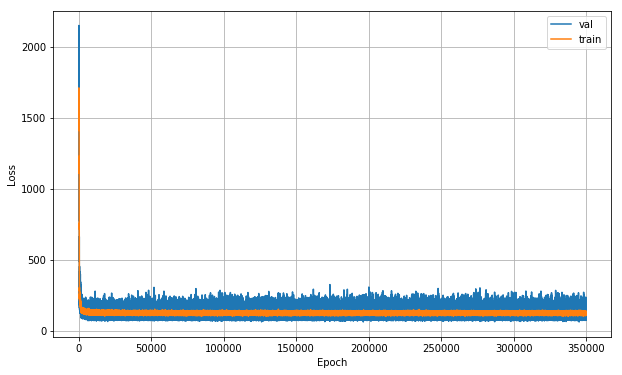

In [166]:
# SHALLOW
v1 = np.load('models/final_models/vlosses_1_2.npy')
t1 = np.load('models/final_models/losses_1_2.npy')
plot_loss(v1, t1, "shallow_curve.png")

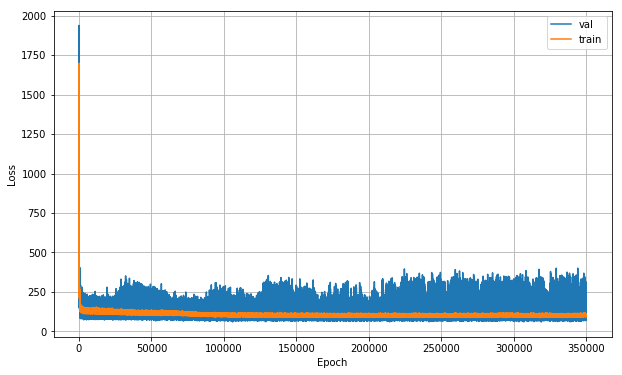

In [167]:
# DEEP
v1 = np.load('models/final_models/vlosses_4_2.npy')
t1 = np.load('models/final_models/losses_4_2.npy')
plot_loss(v1, t1, "deep_curve.png")

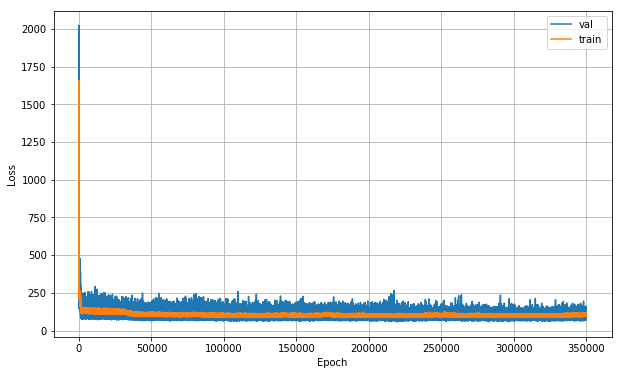

In [168]:
# SUPERDEEP
v1 = np.load('models/final_models/vlosses_6_2.npy')
t1 = np.load('models/final_models/losses_6_2.npy')
plot_loss(v1, t1, "superdeep_curve.png")

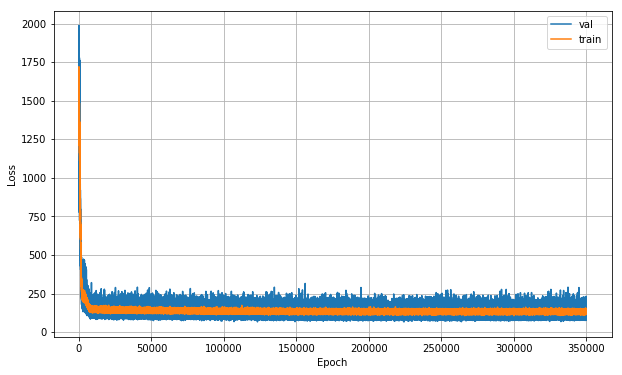

In [169]:
# ASYM SINGLE
v1 = np.load('models/final_models/vlosses_8_2.npy')
t1 = np.load('models/final_models/losses_8_2.npy')
plot_loss(v1, t1, "asym_1_curve.png")

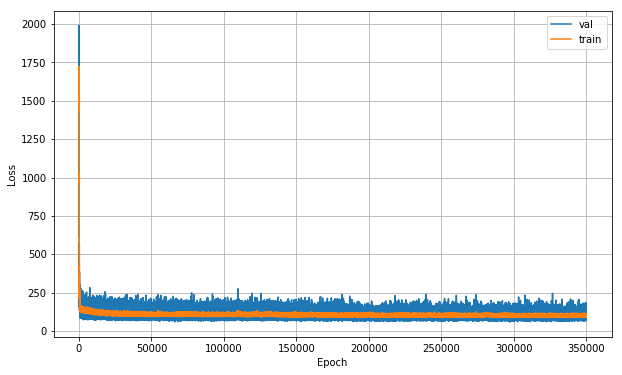

In [170]:
# ASYM MULTI
v1 = np.load('models/final_models/vlosses_5_2.npy')
t1 = np.load('models/final_models/losses_5_2.npy')
plot_loss(v1, t1, "asym_mul_curve.png")

In [28]:
# raw data location
data_path = "rawDataSample.bin"

In [29]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 24
file_directory = 'results/'
file_name = 'ProcessedSpikesNeuropixel'

In [30]:
Probe = NeuroPixel(data_path)
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

H.DetectFromRaw()
H.LoadDetected()

# Sampling rate: 30000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 385
# Analysing frames: 1800000, Seconds:60.0
# Frames before spike in cutout: 30
# Frames after spike in cutout: 66
# tcuts: 42 55
# tInc: 50000
# Analysing 50000 frames; from -42 to 50055
# Analysing 50000 frames; from 49958 to 100055
# Analysing 50000 frames; from 99958 to 150055
# Analysing 50000 frames; from 149958 to 200055
# Analysing 50000 frames; from 199958 to 250055
# Analysing 50000 frames; from 249958 to 300055
# Analysing 50000 frames; from 299958 to 350055
# Analysing 50000 frames; from 349958 to 400055
# Analysing 50000 frames; from 399958 to 450055
# Analysing 50000 frames; from 449958 to 500055
# Analysing 50000 frames; from 499958 to 550055
# Analysing 50000 frames; from 549958 to 600055
# Analysing 50000 frames; from 599958 to 650055
# Analysing 50000 frames; from 649958 to 700055
# Analysing 50000 frames; from 699958 to 750055
# A

In [31]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(95240, 51)


In [35]:
train_lim = (int)(0.85*electrode_data.shape[0])
val_lim = (int)(0.95*electrode_data.shape[0])

#electrode_data_train = electrode_data[:train_lim, :]
#electrode_data_val = electrode_data[train_lim:val_lim, :]
electrode_data_test = electrode_data[val_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (27902, 51)
Test Datasize: (4762, 51)
